<a href="https://colab.research.google.com/github/markonium/AI_Pattern_Recognition/blob/master/%20Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
from scipy import io

# the path to the data set in the drive 
test_path = '/content/drive/MyDrive/data/images/test/'
test_Gtruth = '/content/drive/MyDrive/data/groundTruth/test/'

# here we are reading the image into a np array and convert it into an array of pixel
#the final return is a list with each element in it being a list of 3 elements repersenting the pixel 
#we also read each element in the gt_matrix 
#we return both plus the dimensions of the image since it changes from one to another
def readImg_GT(name):
  img_path = test_path+name
  img = image.imread(img_path)
  x, y, z = img.shape
  converted_img = img.reshape(x*y, z)

  Gtruth = io.loadmat(test_Gtruth + name[:-4])
  mat = []
  for i in range(Gtruth['groundTruth'].shape[1]):
    mat.append(Gtruth['groundTruth'][0][i][0][0][0])
  return converted_img, mat, img.shape

#we reconstrust the image into its original form to be shown and we print each element in the gt matrix 
#this method will be used to print the after cluster image as well
def show(img, gt_mat, dimensions):
  converted_img = img.reshape(dimensions[0], dimensions[1], dimensions[2])
  plt.imshow(converted_img)
  plt.show()

  for i in gt_mat:
    plt.imshow(i)
    plt.show()

#this method changes a gt element (only one not the whole matrix ) to a single dimention array if flatten is true and returns it to normal if false  
def GT_converter(Gt, dimensions, flatten):
  if flatten:
    return Gt.reshape(dimensions[0]* dimensions[1])
  else:
    return Gt.reshape(dimensions[0], dimensions[1])

#we are testing with image 2018 
# img, gt_mat, dimensions = readImg_GT('100007.jpg')


# print(f'Dimensions -> {dimensions}')
# print(img.shape)
# show(img, gt_mat, dimensions)
# Gt = gt_mat[0]
# converted = GT_converter(Gt, dimensions, True)

# converted = GT_converter(converted, dimensions, False)
# print(converted.shape)
# plt.imshow(converted)
# plt.show()
# plt.imshow(Gt)
# plt.show()
# note images have different names and we are only required to work on 50






In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics.cluster import contingency_matrix

def f1_measure(gt_mat, seg_img):
  f1 = 0
  contingency_mat = contingency_matrix(gt_mat, seg_img)
  idx = contingency_mat.argmax(axis=1)
  k = contingency_mat.shape[0]
  for i in range(k):
    ni = contingency_mat.max(axis=1)[i]
    n = np.sum(contingency_mat[i])
    prec = ni / n
    
    tji = contingency_mat[:,idx[i]]
    sum_tji = np.sum(tji)
    rec = ni / sum_tji

    f1 += (2 * prec * rec) / (prec + rec)
  return f1/k


def cond_entropy(gt_mat, seg_img):
    contingency_mat = contingency_matrix(gt_mat, seg_img)
    k = contingency_mat.shape[0]
    htc = 0
    total = sum(contingency_mat.flatten())
    for i in range(k):
      ni = np.sum(contingency_mat[i])
      htci = 0
      for j in range(contingency_mat.shape[1]):
        p = contingency_mat[i][j] / ni
        if p != 0:
          htci -= (p * math.log(p,2))
      htc += (ni/total) * htci
    return htc




In [ ]:
from random import randrange
import math
import copy
def kmeans(k, pixels):
  centroids = []
  colors = []
  clusters = []
  pixels_colors = [None] * len(pixels)
  pixels_num = [None] * len(pixels)
  # Generating a random centroid and a random color for each cluster
  rand_arr = []
  prev_colors = []
  for i in range(k):
    r = randrange(len(pixels))
    while r in rand_arr:
      r = randrange(len(pixels))
    rand_arr.append(r)
    centroids.append(pixels[r])

    color = [randrange(255), randrange(255), randrange(255)]
    while color in prev_colors:
      color = [randrange(255), randrange(255), randrange(255)]
    colors.append(color)
    prev_colors.append(color)

    clusters.append([])
  new_centroids = copy.deepcopy(centroids)
  itr = 0
  while True:
      itr += 1
      centroids = copy.deepcopy(new_centroids)
      # Clustering each pixel
      for j in range(len(pixels)):
        dist = []
        # Calculating euclidean distances to each centroid
        for i in range(k):
          dist.append(np.linalg.norm(np.array(pixels[j]) - np.array(centroids[i])))
        cluster_no = get_cluster(dist)
        clusters[cluster_no].append(pixels[j])
        pixels_colors[j] = colors[cluster_no]
        pixels_num[j] = cluster_no
  
      # Calculating new centroids
      for i in range(k):
        cluster = clusters[i]
        x = 0
        y = 0
        z = 0
        for j in range(len(cluster)):
          x += (cluster[j])[0]
          y += (cluster[j])[1]
          z += (cluster[j])[2]
        # If cluster is already empty don't change its centroid
        if len(cluster) > 0:
          x = x // len(cluster)
          y = y // len(cluster)
          z = z // len(cluster)
          new_centroids[i] = [x,y,z]
      # Chech if convergence achieved
      if check_convrg(new_centroids, centroids) or (itr > 50):
        # print(len(clusters[0]) + len(clusters[1]) + len(clusters[2]))
        return np.array(pixels_colors), np.array(pixels_num)
      for i in range(k):
        clusters[i] = []
  
def get_cluster(dist):
  min_dist = min(dist)
  return dist.index(min_dist)

# Color the pixels in the same cluster with the same color to distinguish them
def segmentation(pixels, clusters, colors):
  new_pixels = copy.deepcopy(pixels)
  print('Copied pixels')
  for i in range(len(clusters)):
    cluster = clusters[i]
    for j in range(len(cluster)):
      indx = new_pixels.index(cluster[j])
      new_pixels[indx] = colors[i]
    print(f'Cluster {i} done')
  return new_pixels

# Check convergence by verifying whether the centroids changed or not
def check_convrg(new_centroids, centroids):
  for i in range(len(centroids)):
    if centroids[i] != new_centroids[i]:
      return 0
  return 1



K = 3


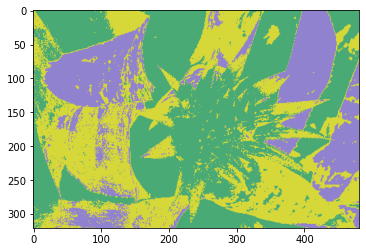

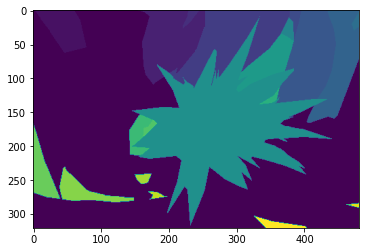

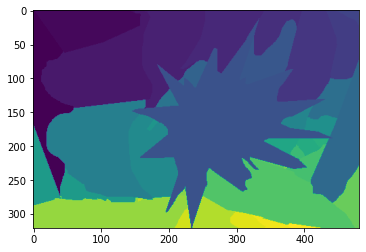

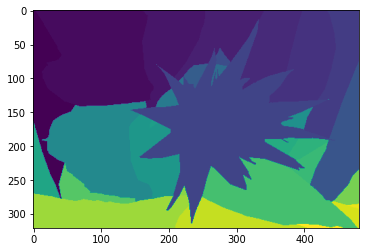

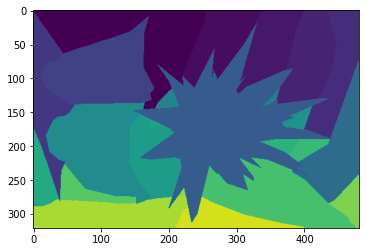

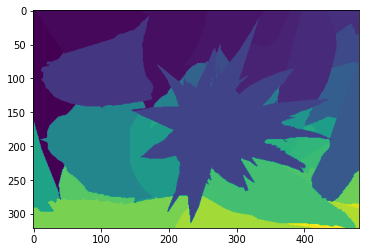

For ground truth 0: f1 measure = 0.09677362242679838, conditional entropy = 1.1400863022534466
For ground truth 1: f1 measure = 0.08366691364054388, conditional entropy = 0.8023408869773697
For ground truth 2: f1 measure = 0.10278124237298748, conditional entropy = 0.8878561010147255
For ground truth 3: f1 measure = 0.11630450393499459, conditional entropy = 0.8261729787671038
For ground truth 4: f1 measure = 0.07588008741971111, conditional entropy = 0.7414279353298643
At k = 3: average f1 measure = 0.09508127395900709, average conditional entropy = 0.8795768408685021

K = 5


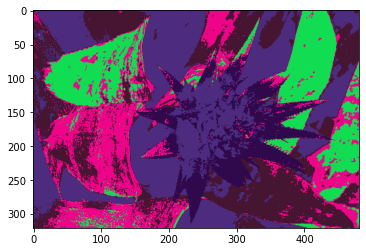

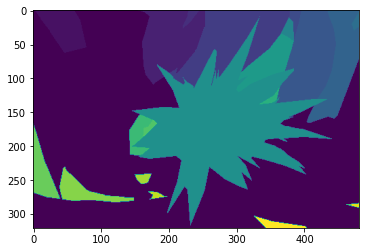

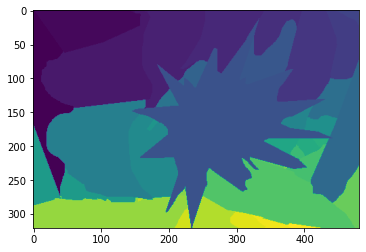

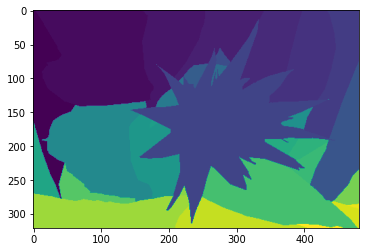

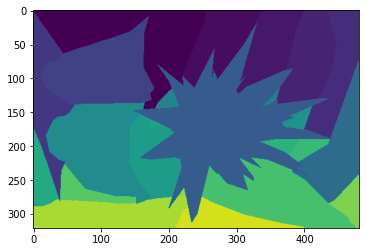

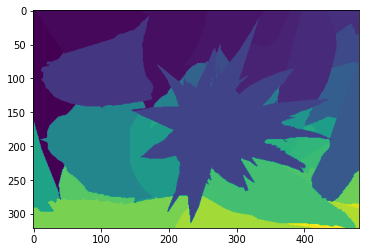

For ground truth 0: f1 measure = 0.11884896877089994, conditional entropy = 1.5101619492970908
For ground truth 1: f1 measure = 0.11005775538226402, conditional entropy = 1.080147270292748
For ground truth 2: f1 measure = 0.13325834040402976, conditional entropy = 1.1879999422510563
For ground truth 3: f1 measure = 0.1483529355148201, conditional entropy = 1.1396840679731162
For ground truth 4: f1 measure = 0.1004262683350372, conditional entropy = 1.0127110112506719
At k = 5: average f1 measure = 0.12218885368141019, average conditional entropy = 1.1861408482129367

K = 7


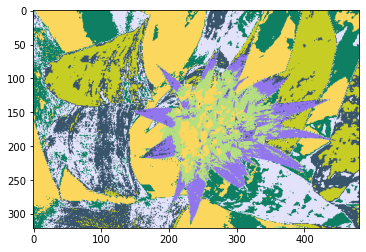

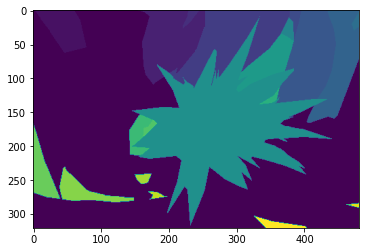

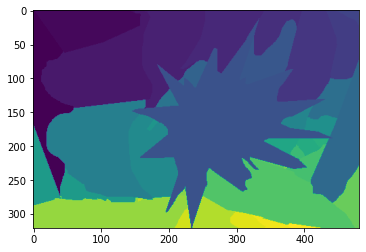

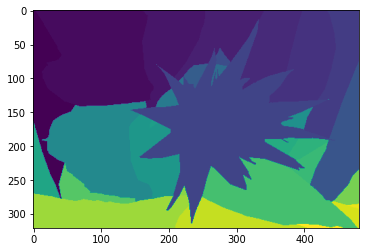

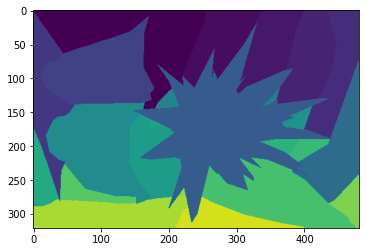

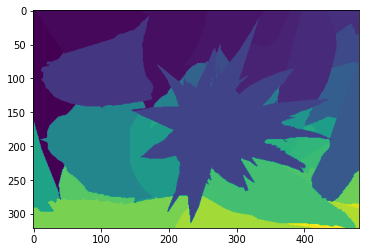

For ground truth 0: f1 measure = 0.12388002469209856, conditional entropy = 1.831580788855227
For ground truth 1: f1 measure = 0.11622532376764326, conditional entropy = 1.3753646440036207
For ground truth 2: f1 measure = 0.13598693050327454, conditional entropy = 1.4914924495424784
For ground truth 3: f1 measure = 0.15030360035748483, conditional entropy = 1.4494986980888231
For ground truth 4: f1 measure = 0.10352639579779799, conditional entropy = 1.3194942763275659
At k = 7: average f1 measure = 0.12598445502365982, average conditional entropy = 1.493486171363543

K = 9


KeyboardInterrupt: ignored

In [ ]:
def try_images():
  images = ['10081.jpg', '14085.jpg', '14092.jpg', '15011.jpg', '15062.jpg', '16004.jpg', '16068.jpg', '17067.jpg', '20069.jpg', '2018.jpg', '23050.jpg', '28083.jpg', '29030.jpg', '3063.jpg', '33044.jpg', '35028.jpg', '35049.jpg', '36046.jpg', '41006.jpg', '41029.jpg', '41085.jpg', '41096.jpg', '43033.jpg', '43051.jpg', '45000.jpg', '48017.jpg', '48025.jpg', '49024.jpg', '5096.jpg', '51084.jpg', '6046.jpg', '61034.jpg', '64061.jpg', '65084.jpg', '69000.jpg', '69007.jpg', '69022.jpg', '70011.jpg', '70090.jpg', '71076.jpg', '71099.jpg', '77062.jpg', '78098.jpg', '79073.jpg', '80085.jpg', '80090.jpg', '8068.jpg', '81066.jpg', '81090.jpg', '81095.jpg']
  img, gt_mat, dimensions = readImg_GT('51084.jpg')
  f1_ds = []
  ce_ds = []
  for k in [3,5,7,9,11]:
    print(f'K = {k}')
    segmented_img, numbered_img = kmeans(k, img.tolist())
    show(segmented_img, gt_mat, dimensions)
    f1 = []
    ce = []
    for i in range(len(gt_mat)):
      f1_measures = f1_measure(GT_converter(gt_mat[i], dimensions, True), numbered_img)
      f1.append(f1_measures)
      cond_entr = cond_entropy(GT_converter(gt_mat[i], dimensions, True), numbered_img)
      ce.append(cond_entr)
      print(f'For ground truth {i}: f1 measure = {f1_measures}, conditional entropy = {cond_entr}')
    average_f1 = sum(f1)/len(f1)
    average_ce = sum(ce)/len(ce)
    print(f'At k = {k}: average f1 measure = {average_f1}, average conditional entropy = {average_ce}\n')
    f1_ds.append(average_f1)
    ce_ds.append(average_ce)
  print(f'For all Ks, average f1 measure = {sum(f1_ds)/len(f1_ds)}, average conditional entropy = {sum(ce_ds)/len(ce_ds)}\n\n\n')
try_images()
  

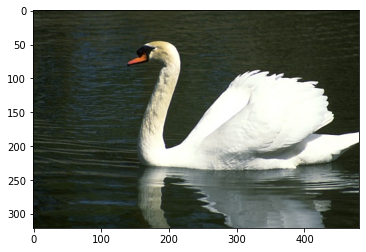

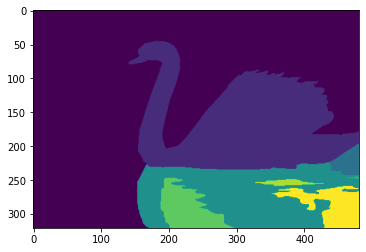

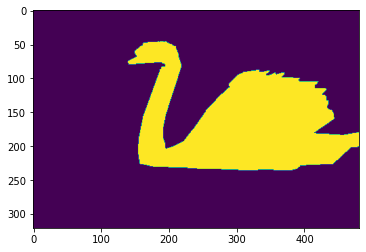

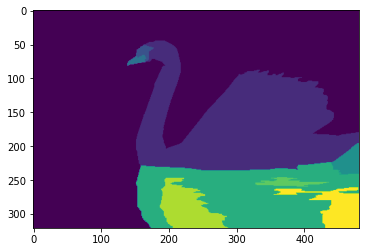

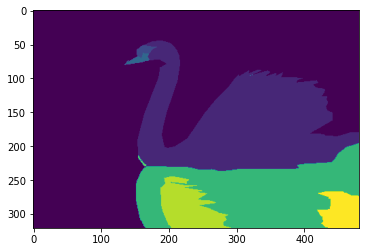

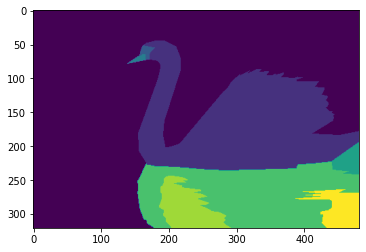

In [ ]:
def display(img):
  img, gt_mat, dimensions = readImg_GT(img)
  show(img, gt_mat, dimensions)

display('8068.jpg')